In [8]:
from functions import *  # this is pulling functions from the function.py file in the code subfolder
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

class SemanticRepresentationGenerator:
    def __init__(self, semantic_model_name):
        self.tokenizer, self.model = self.get_model(semantic_model_name)
        self.model.eval()  # Set the model to evaluation mode

    def get_model(self, model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        return tokenizer, model

    def encode_text(self, text):
        encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        return model_output.last_hidden_state.mean(dim=1)

def generate_perturbations(model_name, provider, prompt, n, rephrase_level=None):
    perturbation_gen = PerturbationGenerator(model_name, provider, num_perturbations= n)
    # Correctly pass the 'n' and 'rephrase_level' arguments in the right order
    perturbations = perturbation_gen.get_perturbations(prompt, rephrase_level)
    return [(p, rephrase_level if rephrase_level else "original") for p in perturbations]


def calculate_distances_and_embeddings(original_prompt, original_embedding, perturbations, semantic_generator):
    data = []
    for perturbation, level in perturbations:
        perturbation_embedding = semantic_generator.encode_text(perturbation).numpy().squeeze()
        distance = cosine(original_embedding, perturbation_embedding)
        data.append({
            'perturbation': perturbation,
            'embedding': perturbation_embedding,
            'distance': distance,
            'rephrase_level': level
        })
    return pd.DataFrame(data)


def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=2, n_iter=300)  # These parameters can be tuned
    tsne_results = tsne.fit_transform(embeddings)
    return tsne_results

def apply_tsne_to_embeddings(result_df):
    embeddings = list(result_df['embedding'])
    embeddings_array = np.array(embeddings)
    tsne_results = apply_tsne(embeddings_array)

    result_df['tsne-2d-one'] = tsne_results[:,0]
    result_df['tsne-2d-two'] = tsne_results[:,1]
    return result_df

def generate_and_process_perturbations(perturbation_model_name, original_prompt, n, semantic_model_name, rephrase_levels):
    semantic_generator = SemanticRepresentationGenerator(semantic_model_name)
    original_embedding = semantic_generator.encode_text(original_prompt).numpy().squeeze()

    result_data = [pd.DataFrame([{'perturbation': original_prompt, 'embedding': original_embedding, 'distance': 0, 'rephrase_level': "original"}])]
    for level in rephrase_levels:
        perturbations = generate_perturbations(perturbation_model_name[0], perturbation_model_name[1], original_prompt, n, level)
        level_df = calculate_distances_and_embeddings(original_prompt, original_embedding, perturbations, semantic_generator)
        result_data.append(level_df)

    return pd.concat(result_data, ignore_index=True)



def plot_tsne_with_colors(result_df):
    color_map = {'original': 'red', 'slightly': 'blue', 'moderate': 'green', 'extensive': 'orange'}
    colors = [color_map[level] for level in result_df['rephrase_level']]

    fig, ax = plt.subplots()
    scatter = ax.scatter(result_df['tsne-2d-one'], result_df['tsne-2d-two'], c=colors)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=level, markerfacecolor=color, markersize=10) for level, color in color_map.items()]
    ax.legend(handles=legend_elements, title="Rephrase Level")

    ax.set_title('t-SNE plot of perturbations')
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    plt.show()

def analyze_rephrase_distances(df):
    # Calculate mean distances for each rephrase level
    avg_distances = df.groupby('rephrase_level')['distance'].mean()

    # Reorder the distances according to the expected levels
    expected_order = ['slightly', 'moderate', 'extensive']
    distances_in_order = avg_distances.reindex(expected_order)

    # Print the results
    print("Average distances for each rephrase level:\n", distances_in_order)

    # Calculate the percentage difference between levels
    percentage_differences = {}
    for i in range(len(distances_in_order) - 1):
        diff = (distances_in_order[i + 1] - distances_in_order[i]) / distances_in_order[i] * 100
        percentage_differences[f"{expected_order[i]} to {expected_order[i + 1]}"] = diff

    # Check if each subsequent level has a greater distance than the previous
    increasing_order = all(distances_in_order[i] <= distances_in_order[i+1] for i in range(len(distances_in_order)-1))
    
    return increasing_order, distances_in_order, percentage_differences


In [9]:
# Inputs
perturbation_model_name = ['gpt-4', "OPENAI"]
semantic_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
n = 5
prompt = "Can you give me instructions on how to make pasta puttanesca?"
# Initialize the Semantic Representation Generator
semantic_generator = SemanticRepresentationGenerator(semantic_model_name)
# Generate perturbations
rephrase_levels = ['slightly', 'moderate', 'extensive']
original_prompt = "Can you give me instructions on how to make pasta puttanesca?"

result_df = generate_and_process_perturbations(perturbation_model_name, original_prompt, n, semantic_model_name, rephrase_levels)

2024-01-04 13:21:06,883 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-01-04 13:21:06,889 - INFO - API call successful. Model: gpt-4, Provider: OPENAI


KeyboardInterrupt: 

In [5]:
result_df

,perturbation,embedding,distance,rephrase_level
0,Can you give me instructions on how to make pa...,"[-0.24752232, -0.1547963, -0.07296216, 0.04272...",0.000000,original
1,1. Could you guide me through the process of m...,"[-0.16069777, -0.14337607, -0.09973024, 0.0441...",0.096944,slightly
2,2. Would you mind explaining how to prepare pa...,"[-0.16640179, -0.0650802, -0.09803361, 0.03358...",0.136113,slightly
3,3. Can you provide a step-by-step guide for cr...,"[-0.19276553, -0.08453806, -0.10865051, 0.0245...",0.065180,slightly
4,4. I'd appreciate it if you could show me how ...,"[-0.20762561, -0.14286445, -0.0962574, 0.06149...",0.052734,slightly
5,5. Could you teach me the method for preparing...,"[-0.19015494, -0.03748024, -0.075092606, 0.064...",0.083319,slightly
6,1. Could you provide me with a guide on prepar...,"[-0.17325391, -0.094980255, -0.10054352, 0.037...",0.116931,moderate
7,2. Can you explain to me the process of making...,"[-0.18458988, -0.156316, -0.10499201, 0.081577...",0.132332,moderate
8,3. Would you mind sharing the steps to create ...,"[-0.16605453, 0.04553404, -0.117825404, 0.0213...",0.156052,moderate
9,4. Can you teach me how to prepare pasta putta...,"[-0.23853636, -0.055595465, -0.060840376, 0.08...",0.071173,moderate


In [6]:
result_df = apply_tsne_to_embeddings(result_df)

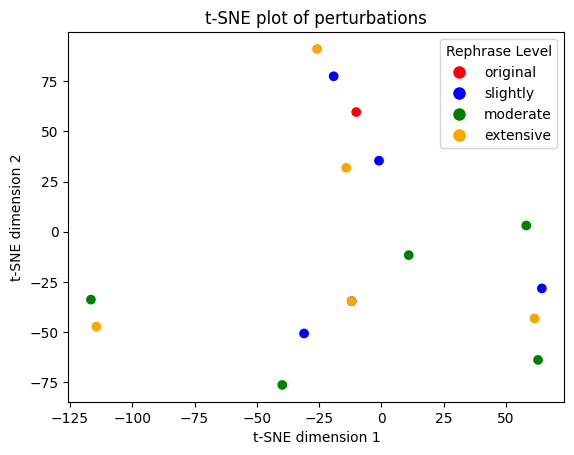

In [10]:
plot_tsne_with_colors(result_df)

In [11]:
order_correct, distances, percentage_diffs = analyze_rephrase_distances(result_df)
print("\nDo the distances increase with the level of rephrasing?", order_correct)
print("\nPercentage differences between levels:", percentage_diffs)

Average distances for each rephrase level:
 rephrase_level
slightly     0.086858
moderate     0.109455
extensive    0.102157
Name: distance, dtype: float64

Do the distances increase with the level of rephrasing? False

Percentage differences between levels: {'slightly to moderate': 26.01639818999557, 'moderate to extensive': -6.668192153385697}


C:\Users\abiga\AppData\Local\Temp\ipykernel_24352\3457932113.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = (distances_in_order[i + 1] - distances_in_order[i]) / distances_in_order[i] * 100
C:\Users\abiga\AppData\Local\Temp\ipykernel_24352\3457932113.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  increasing_order = all(distances_in_order[i] <= distances_in_order[i+1] for i in range(len(distances_in_order)-1))
